In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d thedevastator/german-2021-patient-reviews-and-ratings-of-docto
! unzip -q /content/german-2021-patient-reviews-and-ratings-of-docto.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
german-2021-patient-reviews-and-ratings-of-docto.zip: Skipping, found more recently modified local copy (use --force to force download)


#Importing Libraries

In [ ]:
import os
import random
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import MaxPooling1D, Dropout, Activation, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.14.0


In [ ]:
if os.environ.get('COLAB_GPU', False):
    !pip install -U holoviews hvplot panel==0.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.4/32.4 MB 47.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of holoviews to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 120.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of holoviews to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
CURR_PATH = !pwd
PATH_DATA = CURR_PATH[0]
PATH_MODELS = PATH_DATA + "models/"
PATH_CHECKPOINTS = PATH_MODELS + "checkpoints/"

MAX_FEATURES = 30000
EMBED_DIM = 300
MAXLEN = 400
KERNEL_SIZE = 5
FILTERS = 64
POOL_SIZE = 4
LSTM_OUTPUT_SIZE = 100
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 10

In [ ]:
data = pd.read_csv("/content/2021_german_doctor_reviews.csv")
data["grade_bad"] = 0
data.loc[data["rating"] >= 3, "grade_bad"] = np.nan
data.loc[data["rating"] >= 5, "grade_bad"] = 1

data.head(2)

,index,rating,comment,grade_bad
0,0,2.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!",0.0
1,1,6.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist,er ist unfreundlich ,sehr herablassend und medizinisch unkompetent.Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half.Meine Beschweerden hatten einen völlig anderen Grund.<br />\nNach seiner "" Behandlung "" und Diagnose ,waren seine letzten Worte .....und tschüss.Alles inerhalb von ca 5 Minuten.",1.0


# Data Preprocesing

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%%time
data["comment_clean"] = data.loc[data["comment"].str.len() > 20, "comment"]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 4min 56s, sys: 957 ms, total: 4min 57s
Wall time: 5min 34s


In [ ]:
# Drop Missing
data = data.dropna(axis="index", subset=["grade_bad", "comment_clean"]).reset_index(
    drop=True
)
data.head(2)

,index,rating,comment,grade_bad,comment_clean
0,0,2.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!",0.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen . Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen . Ich habe schnell ein Termin bekommen , das Team war nett und meine schmerzen sind weg ! ! Ich bin als Angst Patient sehr zurieden ! !"
1,1,6.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist,er ist unfreundlich ,sehr herablassend und medizinisch unkompetent.Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half.Meine Beschweerden hatten einen völlig anderen Grund.<br />\nNach seiner "" Behandlung "" und Diagnose ,waren seine letzten Worte .....und tschüss.Alles inerhalb von ca 5 Minuten.",1.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist er ist unfreundlich , sehr herablassend und medizinisch unkompetent Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half Meine Beschweerden hatten einen völlig anderen Grund . Nach seiner Behandlung und Diagnose , waren seine letzten Worte ..... und tschüss Alles inerhalb von ca Minuten ."


In [ ]:
# Sample data for cross validation
train, test = train_test_split(data, random_state=1, test_size=0.25, shuffle=True)
X_train = np.array(train["comment_clean"])
Y_train = np.array(train["grade_bad"]).reshape((-1, 1))
X_test = np.array(test["comment_clean"])
Y_test = np.array(test["grade_bad"]).reshape((-1, 1))
print(X_train.shape)
print(X_test.shape)

(313280,)
(104427,)


In [ ]:
%%time
tokenizer = Tokenizer(lower=True, split=" ", num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train_vec = tokenizer.texts_to_sequences(X_train)
X_test_vec = tokenizer.texts_to_sequences(X_test)
MAXLEN = max([len(x) for x in X_train_vec])
print(f"Max vector length: {MAXLEN}")

Max vector length: 355
CPU times: user 52.7 s, sys: 312 ms, total: 53 s
Wall time: 53.6 s


In [ ]:
X_train_vec = sequence.pad_sequences(X_train_vec, maxlen=MAXLEN, padding="post")
X_test_vec = sequence.pad_sequences(X_test_vec, maxlen=MAXLEN, padding="post")

In [ ]:
tmp = train[0:1].copy()
tmp["vector"] = list(X_train_vec[0:1])
tmp

,index,rating,comment,grade_bad,comment_clean,vector
96604,103454,1.0,"Ich bin seit einigen Jahren wegen ständiger Rückenschmerzen und Verschleiß bei Dr. Behnes in Behandlung. Nach Anhörung meiner Vorgeschichte und gründlicher Untersuchung hat er stets <br />\r\ndie richtige Behandlung und Therapie für mich angewandt,so, dass meine Schmerzen zu ertragen sind.<br />\r\nIch kann die Praxis und das Team nur empfehlen.",0.0,"Ich bin seit einigen Jahren wegen ständiger Rückenschmerzen und Verschleiß bei Dr. Behnes in Behandlung . Nach Anhörung meiner Vorgeschichte und gründlicher Untersuchung hat er stets die richtige Behandlung und Therapie für mich angewandt so , dass meine Schmerzen zu ertragen sind . Ich kann die Praxis und das Team nur empfehlen .","[2, 24, 68, 449, 75, 190, 6092, 1236, 1, 9827, 15, 7, 21012, 8, 38, 40, 17438, 89, 2486, 1, 2028, 137, 17, 25, 191, 3, 504, 38, 1, 374, 22, 16, 6324, 50, 46, 49, 134, 9, 3377, 47, 2, 33, 3, 19, 1, 11, 62, 39, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [ ]:
print(
    f"The comment is transformed to a vector whose first element is \"{tmp['vector'].iloc[0][0]}\". This integer translates to: \"{tokenizer.index_word[tmp['vector'].iloc[0][0]]}\" which is the token representing the original word."
)

The comment is transformed to a vector whose first element is "2". This integer translates to: "ich" which is the token representing the original word.


# Custom Bi-LSTM Model

In [ ]:
# Define NN architecture
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional, GlobalMaxPooling1D

with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_DIM, input_length=MAXLEN)
    )
    model.add(Dropout(0.5))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(Bidirectional(LSTM(LSTM_OUTPUT_SIZE, return_sequences=True)))
    model.add(LSTM(LSTM_OUTPUT_SIZE, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )

In [ ]:
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=2),
    ModelCheckpoint(
        PATH_CHECKPOINTS + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

In [ ]:
%%time
# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 32
Epochs: 10
Step p. Epoch: 9790

Epoch 1/10
9788/9790 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.9110
Epoch 1: val_loss improved from inf to 0.29724, saving model to /contentmodels/checkpoints/2023-12-10_0359_Model_01_0.2972.h5
9790/9790 [==============================] - 260s 26ms/step - loss: 0.3263 - accuracy: 0.9110 - val_loss: 0.2972 - val_accuracy: 0.9123
Epoch 2/10
9790/9790 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.9118
Epoch 2: val_loss improved from 0.29724 to 0.29722, saving model to /contentmodels/checkpoints/2023-12-10_0359_Model_02_0.2972.h5
9790/9790 [==============================] - 199s 20ms/step - loss: 0.2985 - accuracy: 0.9118 - val_loss: 0.2972 - val_accuracy: 0.9123
Epoch 3/10
9789/9790 [============================>.] - ETA: 0s - loss: 0.2985 - accuracy: 0.9117
Epoch 3: val_loss did not improve from 0.29722
9790/9790 [==============================] - 198s 20ms/step - loss: 0.

[Text(0.5, 1.0, 'Model loss'), Text(0, 0.5, '')]

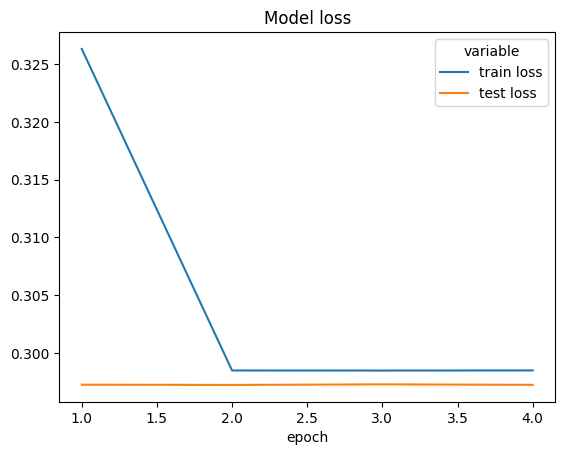

In [ ]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss", ylabel=""
)

In [ ]:
embeddings = model.layers[0].get_weights()[0]
word_index = tokenizer.word_index.items()
words_embeddings = {w: embeddings[idx] for w, idx in word_index if idx < 10000}
words_embeddings.get("arzt")

array([-0.03149404, -0.04877683,  0.02272443,  0.04604959, -0.00251516,
        0.04502724,  0.03268204, -0.02927854, -0.04514123, -0.01142333,
        0.02382562,  0.04407638,  0.04944777, -0.03701378, -0.01573611,
        0.00327052,  0.01692425, -0.02941545,  0.00410399,  0.032194  ,
        0.00335797, -0.03168535,  0.00508817,  0.01363931,  0.00003039,
        0.04148899, -0.04307022,  0.01761159, -0.02519954,  0.01912029,
       -0.04922559, -0.02798421,  0.04553828,  0.01124537, -0.04677105,
        0.02781512,  0.02322266,  0.02794205, -0.04444167,  0.03510978,
       -0.04085898,  0.0314182 , -0.02330872,  0.03523929,  0.03784623,
       -0.01807478,  0.04853201, -0.03647837,  0.01549004, -0.00588187,
        0.02245988,  0.03265071,  0.02727214,  0.03548113, -0.02094643,
       -0.04769496, -0.01379377,  0.04737907,  0.0356878 , -0.02986787,
       -0.00921234, -0.03030691,  0.03303421,  0.03839225,  0.03698774,
       -0.03180782, -0.02077986,  0.00425358,  0.03131489,  0.02

In [ ]:
from sklearn.manifold import TSNE

emb_val = np.array(list(words_embeddings.values()))
emb_name = list(words_embeddings.keys())

tsne = TSNE(n_components=2, random_state=1)
X_2d = tsne.fit_transform(emb_val)

tsne_df = pd.DataFrame({"X": X_2d[:, 0], "Y": X_2d[:, 1], "word": emb_name})
tsne_df.head(3)

,X,Y,word
0,-12.615041,-0.325029,und
1,-25.340725,-25.119513,ich
2,19.449299,-37.856125,die


In [ ]:
! pip install jinja2==3.0.3 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.3
    Uninstalling MarkupSafe-2.1.3:
      Successfully uninstalled MarkupSafe-2.1.3
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.0.0
    Uninstalling Jinja2-3.0.0:
      Successfully uninstalled Jinja2-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(tsne_df[["X", "Y"]])
# get most similar vectors
nearest = tree.query(tsne_df.loc[tsne_df["word"] == "schlecht", ["X", "Y"]], k=5)
tsne_df.iloc[nearest[1][0], :]

,X,Y,word
537,1.887450,4.790135,schlecht
5789,1.807118,4.944119,beruhigung
1241,1.473981,4.554222,verständliche
4388,1.694143,5.242582,darauffolgenden
5851,2.428368,4.605491,gewissheit


In [ ]:
# get most similar vectors
nearest = tree.query(tsne_df.loc[tsne_df["word"] == "gut", ["X", "Y"]], k=5)
tsne_df.iloc[nearest[1][0], :]

,X,Y,word
27,27.909979,-5.845722,gut
4505,27.913412,-5.765968,erwiesen
9206,28.849852,-6.206385,uli
4548,28.894878,-6.213469,verlasse
7819,27.622412,-4.565194,bowen


# Evaluation

In [ ]:
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]

3264/3264 [==============================] - 25s 7ms/step


In [ ]:
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     95267
         1.0       0.00      0.00      0.00      9160

    accuracy                           0.91    104427
   macro avg       0.46      0.50      0.48    104427
weighted avg       0.83      0.91      0.87    104427



# LSTM With Pretrained Embeddings (German FastText embeddings)

In [ ]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz"
!gzip -d cc.de.300.vec.gz

--2023-12-10 04:38:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.114, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1278030050 (1.2G) [binary/octet-stream]
Saving to: ‘cc.de.300.vec.gz’

cc.de.300.vec.gz    100%[===================>]   1.19G  16.3MB/s    in 66s     

2023-12-10 04:39:59 (18.4 MB/s) - ‘cc.de.300.vec.gz’ saved [1278030050/1278030050]



In [ ]:
from gensim.models import KeyedVectors

de_model = KeyedVectors.load_word2vec_format(PATH_DATA + "/cc.de.300.vec")

In [ ]:
de_model.similar_by_word("arzt")[0:5]

[('hausarzt', 0.8440093994140625),
 ('artzt', 0.8014777302742004),
 ('arzt.', 0.7992661595344543),
 ('kinderarzt', 0.7868669629096985),
 ('frauenarzt', 0.7781711220741272)]

In [ ]:
woman = de_model.get_vector("frau")
doctor = de_model.get_vector("arzt")
de_model.similar_by_vector(doctor + woman)

[('arzt', 0.8891545534133911),
 ('frau', 0.7991740703582764),
 ('frauenarzt', 0.782095730304718),
 ('hausarzt', 0.7763659954071045),
 ('ärztin', 0.7679202556610107),
 ('frauenärztin', 0.7507506608963013),
 ('arzthelferin', 0.7356253266334534),
 ('kinderärztin', 0.7130227088928223),
 ('hausärztin', 0.7106521725654602),
 ('kinderarzt', 0.7027797698974609)]

In [ ]:
print("preparing embedding matrix...")
words_not_found = []
word_index = tokenizer.word_index
nb_words = min(MAX_FEATURES, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBED_DIM))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = de_model.get_vector(word)
    except KeyError:
        embedding_vector = None
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(
    f"Some of the words not found:\n"
    f"{' '.join([random.choice(words_not_found) for x in range(0,10)])}"
)

preparing embedding matrix...
Null word embeddings: 8760
Some of the words not found:
terminzusage zahntechnisch zwink behandlungsmethode friedenau hyaluronbehandlung kneissl bahnstation treppenstufen klinkhamels


In [ ]:
with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(
            input_dim=MAX_FEATURES,
            output_dim=EMBED_DIM,
            input_length=MAXLEN,
            weights=[embedding_matrix],
            trainable=True,
        )
    )
    model.add(Dropout(0.3))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(LSTM(LSTM_OUTPUT_SIZE))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 355, 300)          9000000   
                                                                 
 dropout_3 (Dropout)         (None, 355, 300)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 351, 64)           96064     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 87, 64)            0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                      

In [ ]:
%%time
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=2),
    ModelCheckpoint(
        PATH_CHECKPOINTS
        + now
        + "_Model_FT-Embed-trainable_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 32
Epochs: 10
Step p. Epoch: 9790

Epoch 1/10
9789/9790 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9246
Epoch 1: val_loss improved from inf to 0.08820, saving model to /contentmodels/checkpoints/2023-12-10_0450_Model_FT-Embed-trainable_01_0.0882.h5
9790/9790 [==============================] - 218s 22ms/step - loss: 0.2260 - accuracy: 0.9246 - val_loss: 0.0882 - val_accuracy: 0.9661
Epoch 2/10
9790/9790 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9698
Epoch 2: val_loss improved from 0.08820 to 0.07355, saving model to /contentmodels/checkpoints/2023-12-10_0450_Model_FT-Embed-trainable_02_0.0736.h5
9790/9790 [==============================] - 163s 17ms/step - loss: 0.0790 - accuracy: 0.9698 - val_loss: 0.0736 - val_accuracy: 0.9712
Epoch 3/10
9789/9790 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9762
Epoch 3: val_loss improved from 0.07355 to 0.06754, saving model to /contentmod

In [ ]:
# Predict on test data
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

3264/3264 [==============================] - 13s 4ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     95267
         1.0       0.91      0.77      0.83      9160

    accuracy                           0.97    104427
   macro avg       0.94      0.88      0.91    104427
weighted avg       0.97      0.97      0.97    104427



# BERT Based Approach

In [ ]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.14.0


# Feature creation and modeling

In [ ]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

MAXLEN = 192

def preprocess_text(data):
    """ take texts and prepare as input features for BERT
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,
            max_length=MAXLEN,
            pad_to_max_length=True,
            return_attention_mask=False,
        )
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

In [ ]:
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/drive/My Drive/tmp/"

In [ ]:
data.head()

,index,rating,comment,grade_bad,comment_clean
0,0,2.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!",0.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen . Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen . Ich habe schnell ein Termin bekommen , das Team war nett und meine schmerzen sind weg ! ! Ich bin als Angst Patient sehr zurieden ! !"
1,1,6.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist,er ist unfreundlich ,sehr herablassend und medizinisch unkompetent.Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half.Meine Beschweerden hatten einen völlig anderen Grund.<br />\nNach seiner "" Behandlung "" und Diagnose ,waren seine letzten Worte .....und tschüss.Alles inerhalb von ca 5 Minuten.",1.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist er ist unfreundlich , sehr herablassend und medizinisch unkompetent Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half Meine Beschweerden hatten einen völlig anderen Grund . Nach seiner Behandlung und Diagnose , waren seine letzten Worte ..... und tschüss Alles inerhalb von ca Minuten ."
2,2,1.0,Hatte akute Beschwerden am Rücken. Herr Magura war der erste Arzt der sich wirklich Zeit für einen Therapieplan genommen hat um nachhaltig meine Schmerzen zu beseitigen,0.0,Hatte akute Beschwerden am Rücken . Herr Magura war der erste Arzt der sich wirklich Zeit für einen Therapieplan genommen hat um nachhaltig meine Schmerzen zu beseitigen
3,3,1.0,"Nachdem ich in der Klinik nur ungenaue Angaben erhalten habe, welche Sportarten mein herzkranker Sohn machen darf, wandte ich mich an Dr. Roithmaier, den ich bereits bei einer Veranstaltung der Selbsthilfegruppe ""Junge Herzen Bayern"" kennengelernt hatte. Dr. Roithmaier nahm sich sehr viel Zeit, erläuterte die Untersuchung ausführlich und erklärte genau, welche Sportarten infrage kommen und warum andere nicht. Wir sind wirklich sehr gut beraten worden.",0.0,"Nachdem ich in der Klinik nur ungenaue Angaben erhalten habe , welche Sportarten mein herzkranker Sohn machen darf , wandte ich mich an Dr. Roithmaier , den ich bereits bei einer Veranstaltung der Selbsthilfegruppe Junge Herzen Bayern kennengelernt hatte . Dr. Roithmaier nahm sich sehr viel Zeit , erläuterte die Untersuchung ausführlich und erklärte genau , welche Sportarten infrage kommen und warum andere nicht . Wir sind wirklich sehr gut beraten worden ."
4,4,1.0,"Frau Dr. Vetter kenne ich seit vielen Jahren, sie hat mir bei vielen Problemen sehr kompetent und sehr <br />\numsichtig geholfen. Sie hat mich immer aufgerichtet, wenn es mir schlecht ging.Und sie hat auch viel Ahnung von anderen Fachgebieten. Ich bin sehr zufrieden und kann sie nur wärmstens empfehlen.<br />\nGestern war ich mit meiner Tochter bei ihr . Auch sie war total begeistert.",0.0,"Frau Dr. Vetter kenne ich seit vielen Jahren , sie hat mir bei vielen Problemen sehr kompetent und sehr umsichtig geholfen . Sie hat mich immer aufgerichtet , wenn es mir schlecht ging Und sie hat auch viel Ahnung von anderen Fachgebieten . Ich bin sehr zufrieden und kann sie nur wärmstens empfehlen . Gestern war ich mit meiner Tochter bei ihr . Auch sie war total begeistert ."


In [ ]:
comment = ["Ich liebe data-dive.com und meine Katze."]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Comment:  ['Ich liebe data-dive.com und meine Katze.']
Tokenized Comment:  ['[CLS]', 'Ich', 'liebe', 'dat', '##a', '-', 'di', '##ve', '.', 'c', '##om', 'und', 'meine', 'Katze', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Token IDs:  [3, 1671, 16619, 10453, 26903, 26935, 4616, 2304, 26914, 1350, 101, 42, 6667, 25285, 26914, 4, 0, 0, 0, 0]


In [ ]:
%%time
import pickle

input_ids = preprocess_text(data["comment_clean"])

CPU times: user 11min 18s, sys: 12.2 s, total: 11min 30s
Wall time: 13min 42s


In [ ]:
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["grade_bad"], random_state=1, test_size=0.25, shuffle=True
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 313280
Test set: 104427


In [ ]:
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 8
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

def build_model(transformer, max_len=MAXLEN):
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(1, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset

train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

In [ ]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 192)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109081344 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 192, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [ ]:
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
]

In [ ]:
%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    callbacks=callbacks,
)

Model Params:
batch_size: 16
Epochs: 8
Step p. Epoch: 19580
Learning rate: 1e-05
Epoch 1/8


 2916/19580 [===>..........................] - ETA: 4:00:45 - loss: 0.3255 - accuracy: 0.9122

In [ ]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

# Evaluation

In [ ]:
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

In [ ]:
pred_class = (pred > 0.5).astype(int)
report = metrics.classification_report(test_labels, pred_class)
print(report)